# Splitting the Posterior Files based on Velocity

So when I split up the original posterior file, it really only worked for the maximum likelihood velocity and not the pixels that has multiple velocity components. That resulted in some kind of weird things going on like the attached figure here, where you can see some very sharp changes in places that don't always make sense. What I would like to do here is use a peak finder or a gradient decomposition to pull out all of the actual peaks and break it down that way. That way, I can have one graph that shows all of the redder gas and one that shows all of the bluer gas without there being these false gradients and line of sight confusion that you see here.

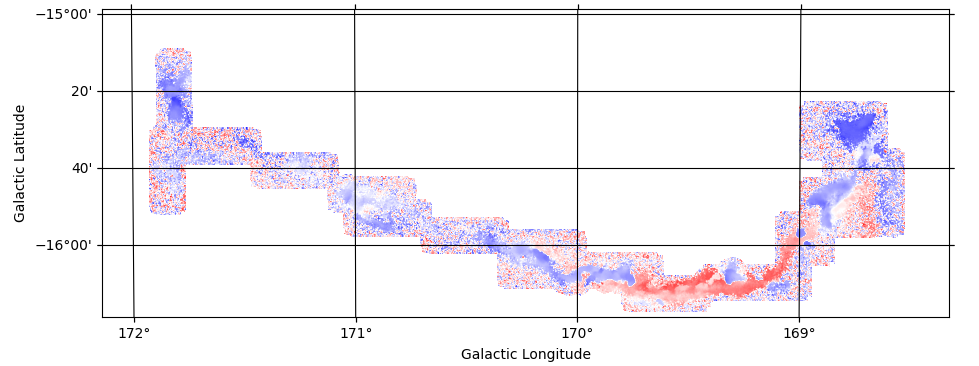

I think what I would like to do is run a Gaussian decomposition software on every pixel. If it locates more than one peak within a certain range of velocities, then the pdf gets split in between the velocities. Each peak would get appended to a certain map depending on it's velocity. If there isn't a peak there, then it won't append anything. The problem with this could be if there is a big enough gradient over an extended space to make sure to put those together instead of splitting them and trying to combine two pieces that don't fit together just because they have the same velocities.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io
from astropy.io import fits
import pandas as pd
import matplotlib as mpl
from astropy import wcs
from astropy.coordinates import SkyCoord
import pickle
import math
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from tqdm import tqdm

import os

%matplotlib inline
import matplotlib.pyplot as plt

In [241]:
path = 'v1_voff_post.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header
print(header)

wcs_velocities = wcs.WCS(header)
print(wcs_velocities)
print(data.shape)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 2200                                                  NAXIS2  =                  800                                                  NAXIS3  =                  199                                                  CDELT1  =      -0.001666666707                                                  CDELT2  =       0.001666666707                                                  CRPIX1  =               1100.0                                                  CRPIX2  =               9785.0                                                  CRVAL1  =        170.233333333                                                  CRVAL2  =                  0.0                                                  CTYPE1  = 'GLON-SFL'                    

0.23132529854774475
6.582410135163471
[123]
6.582410135163471


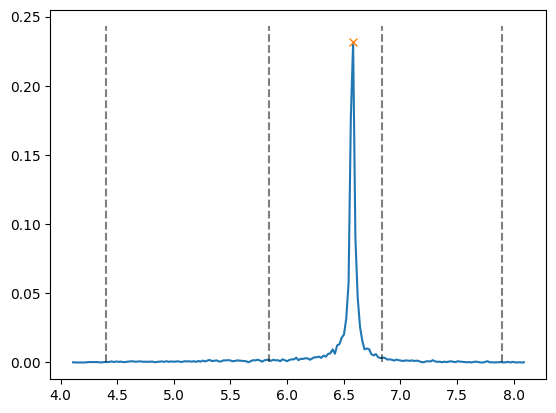

In [244]:
vel_start = header["CRVAL3"]
vel_inc = header["CDELT3"]

v_channels = np.arange(header["NAXIS3"])

#define velocity as km/s blocks
velocity = vel_start + (vel_inc * v_channels)
velocity = np.array(velocity, dtype = float)

posterior_dist = data[:, 42, 1444]

peaks, _ = find_peaks(posterior_dist, height=np.nanmax(posterior_dist) * 0.05, 
                      distance = 20, 
                      prominence = np.nanmax(posterior_dist) * 0.06, 
                     width = [1, 15])
heights = _['peak_heights']

print(sorted(heights, reverse = True)[0])
print(velocity[list(posterior_dist).index(sorted(heights, reverse = True)[0])])
print(peaks)
for i in range(len(peaks)):
    print(velocity[list(posterior_dist).index(sorted(heights, reverse = True)[i])])

plt.figure()
plt.plot(velocity, posterior_dist)
plt.plot(velocity[peaks], posterior_dist[peaks], "x")
plt.vlines(4.4, np.min(posterior_dist), np.max(posterior_dist)*1.05, colors = 'black', linestyle = 'dashed', alpha = 0.5)
plt.vlines(5.84, np.min(posterior_dist), np.max(posterior_dist)*1.05, colors = 'black', linestyle = 'dashed', alpha = 0.5)
plt.vlines(6.84, np.min(posterior_dist), np.max(posterior_dist)*1.05, colors = 'black', linestyle = 'dashed', alpha = 0.5)
plt.vlines(7.9, np.min(posterior_dist), np.max(posterior_dist)*1.05, colors = 'black', linestyle = 'dashed', alpha = 0.5)

Loop over every pixel and find the peaks based off of some really liberal conditions to try to cast as wide of a net on capturing the peaks as possible. The only condition that is designed to limit the peaks that are pulled out is the height. From some trial and error, I found that most of the noise seems to be around ~0.0075 or lower, which is why I set that limit. I should really go through and figure out what an rms is across all of the pixels so that I can give a more statistically driven limit.

Then based on what velocities the peaks are identified to be at, they are put into bins. Because of some of the structures in each of the regions, the bins change a little bit to be able to capture all of the gas that seems to be connected to each other within the same frame. If there isn't an identified peak within that bin, then NaN is appended so that we don't take false gradients with noise.

In [232]:
peaks_grid_1 = []
peaks_grid_2 = []
peaks_grid_3 = []
for i in tqdm(range(800)):
    row_number_1 = []
    row_number_2 = []
    row_number_3 = []
    for j in range(2200):
        posterior_dist = data[:, i, j]
        if math.isnan(np.sum(posterior_dist)):
            row_number_1.append(np.sum(posterior_dist))
            row_number_2.append(np.sum(posterior_dist))
            row_number_3.append(np.sum(posterior_dist))
        else:
            peaks, _ = find_peaks(posterior_dist, #height=np.nanmax(posterior_dist) * 0.05, 
                                  height = 0.01,
                                  distance = 20, 
                                  prominence = np.nanmax(posterior_dist) * 0.05,
                                  width = [1, 15])
            heights = _['peak_heights']

            specific_heights = []
            for l in range(len(heights)):
                specific_heights.append(velocity[list(posterior_dist).index(sorted(heights, reverse = True)[l])])
            bin_1 = []
            bin_2 = []
            bin_3 = []
            if 450< j < 700:
                for k in specific_heights:
                    if 4.4 < k < 5.84:
                        bin_1.append(k)
                    elif 5.84 < k < 6.89:
                        bin_2.append(k)
                    elif 6.89 < k < 7.9:
                        bin_3.append(k)
            else:
                for k in specific_heights:
                    if 4.4 < k < 5.86:
                        bin_1.append(k)
                    elif 5.86 < k < 6.84:
                        bin_2.append(k)
                    elif 6.84 < k < 7.9:
                        bin_3.append(k)
            if len(bin_1) >= 1:
                row_number_1.append(bin_1[0])
            else:
                row_number_1.append(data[0, 100, 1000])

            if len(bin_2) >= 1:
                row_number_2.append(bin_2[0])
            else:
                row_number_2.append(data[0, 100, 1000])

            if len(bin_3) >= 1:
                row_number_3.append(bin_3[0])
            else:
                row_number_3.append(data[0, 100, 1000])
            
    peaks_grid_1.append(row_number_1)
    peaks_grid_2.append(row_number_2)
    peaks_grid_3.append(row_number_3)

100%|█████████████████████████████████████████| 800/800 [00:29<00:00, 27.37it/s]


In [236]:
output_hdu = wcs_velocities.to_fits()
output_hdu[0].data is None

output_hdu[0].data = peaks_grid_1

output_hdu.writeto("velocity_grid_440-586.fits", overwrite=True)

output_hdu = wcs_velocities.to_fits()
output_hdu[0].data is None

output_hdu[0].data = peaks_grid_2

output_hdu.writeto("velocity_grid_586-684.fits", overwrite=True)

output_hdu = wcs_velocities.to_fits()
output_hdu[0].data is None

output_hdu[0].data = peaks_grid_2

output_hdu.writeto("velocity_grid_684-790.fits", overwrite=True)

/tmp/ipykernel_9695/4023371073.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('bwr')
/tmp/ipykernel_9695/4023371073.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('bwr')
/tmp/ipykernel_9695/4023371073.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('bwr')


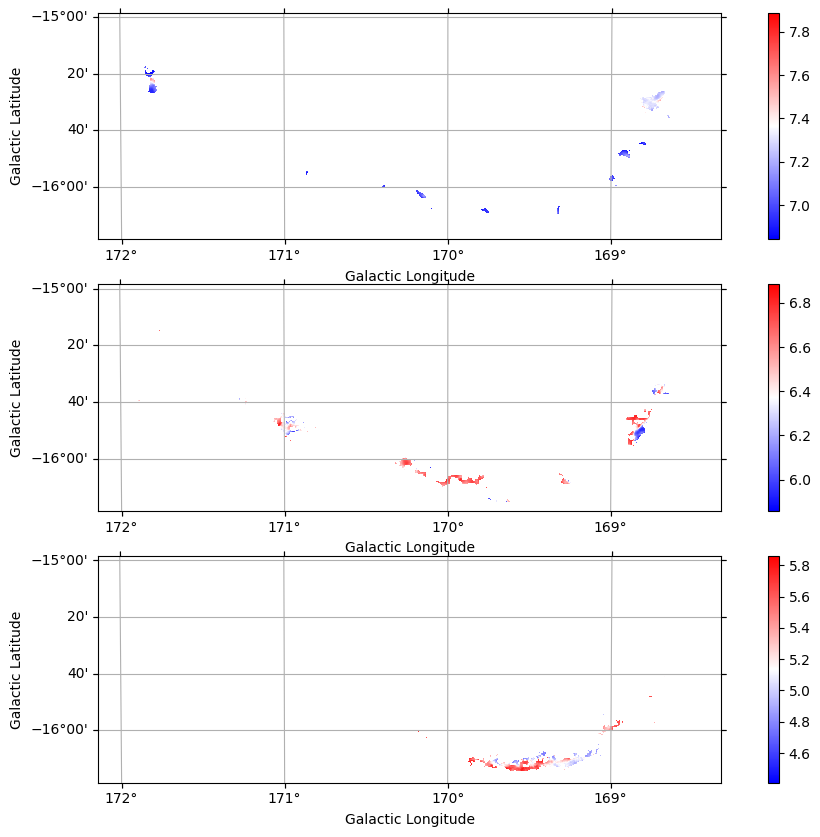

In [233]:
plt.figure(figsize = [12, 10])

ax = plt.subplot(311, projection = wcs_velocities, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('bwr')
im = ax.imshow(peaks_grid_3, origin = 'lower', cmap = cm)
ax.grid()
plt.colorbar(im)
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

ax = plt.subplot(312, projection = wcs_velocities, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('bwr')
im = ax.imshow(peaks_grid_2, origin = 'lower', cmap = cm)
ax.grid()
plt.colorbar(im)
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

ax = plt.subplot(313, projection = wcs_velocities, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('bwr')
im = ax.imshow(peaks_grid_1, origin = 'lower', cmap = cm)
ax.grid()
plt.colorbar(im)
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

plt.savefig('Velocity Breakdown.png', bbox_inches = 'tight')

## Zooming in on each of these regions and taking gradients

From the other files that I made, we know what the regions are. We also have all of the spine fits, so we can take the differential 1-form, decompose that into the angles (using trigonometry) and then take the dot products between the spine gradients and the velocity gradients. Let's maybe start with B211. Then do the main regions around the middle velocities, and then the small isolated cores that are all at the highest and reddest velocities.

In [197]:
path = 'distance_transform.fits'
cube = fits.open(path)
distance_transform_data = cube[0].data
header = cube[0].header
#print(header)

wcs_dist_transform = wcs.WCS(header)

print(wcs_dist_transform)
print(distance_transform_data.shape)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SFL' 'GLAT-SFL' 'v' 
CRVAL : np.float64(170.233333333) np.float64(0.0) np.float64(4.1100502434622) 
CRPIX : np.float64(1100.0) np.float64(9785.0) np.float64(0.0) 
PC1_1 PC1_2 PC1_3  : np.float64(1.0) np.float64(0.0) np.float64(0.0) 
PC2_1 PC2_2 PC2_3  : np.float64(0.0) np.float64(1.0) np.float64(0.0) 
PC3_1 PC3_2 PC3_3  : np.float64(0.0) np.float64(0.0) np.float64(1.0) 
CDELT : np.float64(-0.001666666707) np.float64(0.001666666707) np.float64(0.020100486924401) 
NAXIS : 2200  800
(800, 2200)


/tmp/ipykernel_9695/3267255772.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('magma_r')


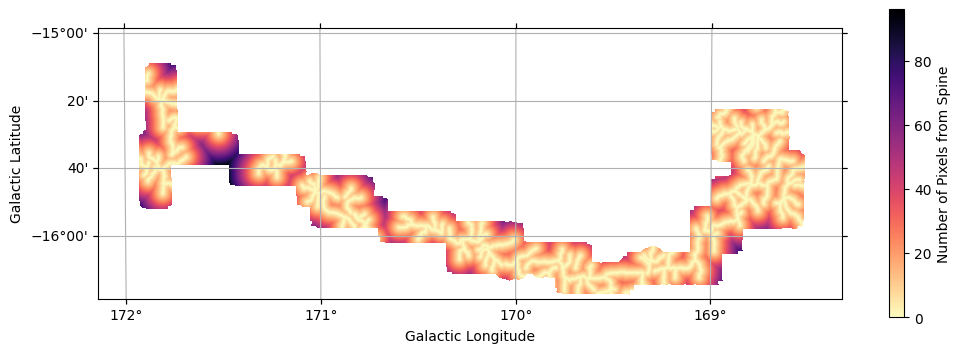

In [198]:
plt.figure(figsize = [12,4])
ax = plt.subplot(projection=wcs_dist_transform, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('magma_r')
plt.imshow(distance_transform_data, origin = 'lower', cmap = cm)
plt.colorbar(label = 'Number of Pixels from Spine')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.grid()

In [237]:
path = 'velocity_grid_440-586.fits'
cube = fits.open(path)
low_vels_data = cube[0].data
header = cube[0].header
#print(header)

wcs_low_vels = wcs.WCS(header)

print(wcs_low_vels)
print(low_vels_data.shape)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SFL' 'GLAT-SFL' 'v' 
CRVAL : np.float64(170.233333333) np.float64(0.0) np.float64(4.1100502434622) 
CRPIX : np.float64(1100.0) np.float64(9785.0) np.float64(0.0) 
PC1_1 PC1_2 PC1_3  : np.float64(1.0) np.float64(0.0) np.float64(0.0) 
PC2_1 PC2_2 PC2_3  : np.float64(0.0) np.float64(1.0) np.float64(0.0) 
PC3_1 PC3_2 PC3_3  : np.float64(0.0) np.float64(0.0) np.float64(1.0) 
CDELT : np.float64(-0.001666666707) np.float64(0.001666666707) np.float64(0.020100486924401) 
NAXIS : 2200  800
(800, 2200)


In [196]:
path = 'B211_velocity_posterior.fits'
cube = fits.open(path)
B211_post_data = cube[0].data
header = cube[0].header
#print(header)

wcs_B211 = wcs.WCS(header)

print(wcs_B211)
print(B211_post_data.shape)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SFL' 'GLAT-SFL' 'v' 
CRVAL : np.float64(170.233333333) np.float64(0.0) np.float64(4.1100502434622) 
CRPIX : np.float64(-294.0) np.float64(9775.0) np.float64(0.0) 
PC1_1 PC1_2 PC1_3  : np.float64(1.0) np.float64(0.0) np.float64(0.0) 
PC2_1 PC2_2 PC2_3  : np.float64(0.0) np.float64(1.0) np.float64(0.0) 
PC3_1 PC3_2 PC3_3  : np.float64(0.0) np.float64(0.0) np.float64(1.0) 
CDELT : np.float64(-0.001666666707) np.float64(0.001666666707) np.float64(0.020100486924401) 
NAXIS : 353  133  199
(199, 133, 353)


169.72110278036524 169.10942475435078
-16.290000394218 -16.068333722187
1394 1747
10 143


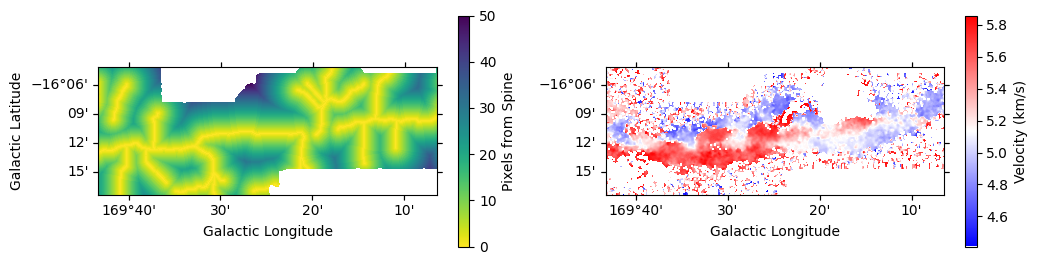

In [234]:
(l_min, b_min, vel), (l_max, b_max, vel) = wcs_B211.wcs_pix2world([[0, 0, 0], [353, 133, 0]], 0)

print(l_min, l_max)
print(b_min, b_max)

(l_min, b_min, vel), (l_max, b_max, vel) = wcs_dist_transform.wcs_world2pix([[l_min, b_min, 0], [l_max, b_max, 0]], 0)

print(round(l_min), round(l_max))
print(round(b_min), round(b_max))

subregion = distance_transform_data[round(b_min):round(b_max), round(l_min):round(l_max)]

plt.figure(figsize = [12, 3])
ax_1 = plt.subplot(122, projection = wcs_dist_transform, slices=('x', 'y', 0))
im = ax_1.imshow(peaks_grid_1, cmap = 'bwr')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
ax_1.set(xlim=(l_min, l_max), ylim=(b_min, b_max))
cbar = plt.colorbar(im, label = 'Velocity (km/s)')

ax_1 = plt.subplot(121, projection = wcs_dist_transform, slices=('x', 'y', 0))
im = ax_1.imshow(distance_transform_data, cmap = 'viridis_r', vmax = np.nanmax(subregion))
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
ax_1.set(xlim=(l_min, l_max), ylim=(b_min, b_max))
cbar = plt.colorbar(im, label = 'Pixels from Spine')

120 120


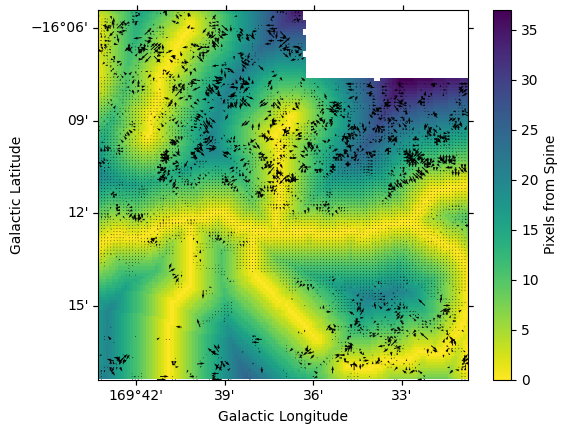

In [239]:
def divergence(scalar_field):
    gx, gy = np.gradient(scalar_field)
    return(gx, gy)

a, b = 233, 13
l, m = 0, 0

subregion = low_vels_data[round(b_min+m):round(b_max-b), round(l_min+l):round(l_max-a)]
grad_y, grad_x = divergence(subregion) #Flip the order because the coordinates get put in (b, l) and not (l, b)
#print(grad_x)

x = np.arange(round(l_min+l), round(l_max-a), 1)
y = np.arange(round(b_min+m), round(b_max-b), 1)
print(len(x), len(y))

#x, y = np.meshgrid(x, y, indexing = 'ij', sparse = False)

#plt.figure(figsize = (20, 10))
ax_1 = plt.subplot(projection = wcs_dist_transform, slices=('x', 'y', 0))
im = ax_1.imshow(distance_transform_data, cmap = 'viridis_r', vmax = np.nanmax(distance_transform_data[round(b_min+m):round(b_max-b), round(l_min+l):round(l_max-a)]))
plt.quiver(x, y, grad_x, grad_y, color = 'black')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
ax_1.set(xlim=(l_min+l, l_max-a), ylim=(b_min+m, b_max-b))
cbar = plt.colorbar(im, label = 'Pixels from Spine')